In [ ]:
# 1) Mount Google Drive (DO NOT EDIT)

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === EDIT THIS CELL ONLY ===

# Folder containing your dataset
BASE_DIR = "/content/drive/MyDrive/CSCI 218 - Foundations Of AI"

# Abalone CSV filename (make sure it matches exactly in Drive)
CSV_FILENAME = "abalone.csv"

# Full path to dataset
DATA_PATH = f"{BASE_DIR}/{CSV_FILENAME}"

# =====================================


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor


In [ ]:
# 4) Dataset Loader (Abalone CSV)
import os

# Derived path
csv_path = os.path.join(BASE_DIR, "abalone.csv")

print("BASE_DIR :", BASE_DIR)
print("CSV expected at :", csv_path)

file_exists = os.path.exists(csv_path)
print("File exists? :", file_exists)


if not file_exists:
    raise FileNotFoundError(
        "\n Could not find the dataset.\n"
        "Please ensure that:\n"
        f" • 'abalone.csv' exists inside:\n"
        f"   {BASE_DIR}\n"
    )

#Load dataset
print("\nLoading dataset from Drive...")
df = pd.read_csv(csv_path)

print("\n Dataset loaded successfully.")
print("Shape :", df.shape)
df.head()


BASE_DIR : /content/drive/MyDrive/CSCI 218 - Foundations Of AI
CSV expected at : /content/drive/MyDrive/CSCI 218 - Foundations Of AI/abalone.csv
File exists? : True

Loading dataset from Drive...

 Dataset loaded successfully.
Shape : (4177, 9)


,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
print("\nColumns:", df.columns.tolist())
print("\nMissing values per column:\n", df.isnull().sum())




Columns: ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']

Missing values per column:
 Sex              0
Length           0
Diameter         0
Height           0
WholeWeight      0
ShuckedWeight    0
VisceraWeight    0
ShellWeight      0
Rings            0
dtype: int64


In [ ]:
# Regression target: Age = Rings + 1.5 (common approximation)
df["Age"] = df["Rings"] + 1.5

# Classification target: age-group based on Rings (estimate age group can be changed)
def rings_to_group(r):
    if r <= 8:
        return "Young"
    elif r <= 10:
        return "Middle-aged"
    else:
        return "Old"

df["AgeGroup"] = df["Rings"].apply(rings_to_group)

print("\nClass distribution:\n", df["AgeGroup"].value_counts())



Class distribution:
 AgeGroup
Old            1447
Young          1407
Middle-aged    1323
Name: count, dtype: int64


In [ ]:
# 5) Split features vs targets
X = df.drop(columns=["Rings", "Age", "AgeGroup"])  # predictors
y_class = df["AgeGroup"]
y_reg = df["Age"]

# Identify categorical + numeric columns
cat_cols = ["Sex"]
num_cols = [c for c in X.columns if c not in cat_cols]

print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)



Numeric columns: ['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight']
Categorical columns: ['Sex']


In [ ]:
# 6) Preprocessing (OneHot for Sex, scaling for numeric)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ]
)


PART A: CLASSIFICATION (Young/Middle-aged/Old)

In [ ]:
# 7A) Train-test split (stratified for classification)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X,
    y_class,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_class
)

print("\n[Classification] Train size:", X_train_c.shape[0])
print("[Classification] Test size :", X_test_c.shape[0])



[Classification] Train size: 3341
[Classification] Test size : 836


In [ ]:
# 8A) Models
# Baseline 1: Logistic Regression (multinomial)
clf_lr = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
])

# Baseline 2: Random Forest
clf_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE
    ))
])



=== Classification: Logistic Regression ===
Accuracy: 0.6603

Classification report:
              precision    recall  f1-score   support

 Middle-aged     0.5133    0.5094    0.5114       265
         Old     0.6978    0.6690    0.6831       290
       Young     0.7559    0.7936    0.7743       281

    accuracy                         0.6603       836
   macro avg     0.6557    0.6573    0.6563       836
weighted avg     0.6589    0.6603    0.6593       836



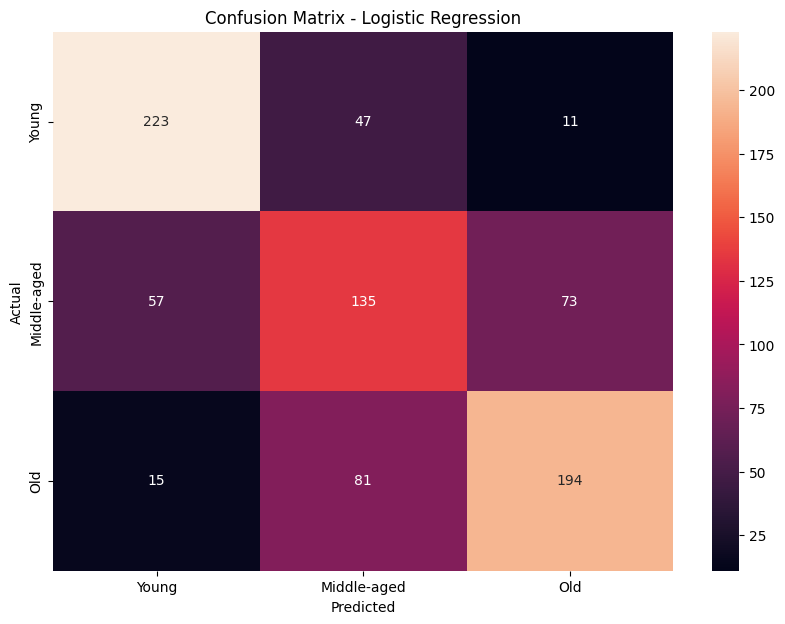

Per-class accuracy (LR):
Young: 0.7936
Middle-aged: 0.5094
Old: 0.6690


In [ ]:
# 9A) Train + Evaluate (Logistic Regression)
print("\n=== Classification: Logistic Regression ===")
clf_lr.fit(X_train_c, y_train_c)
y_pred_lr = clf_lr.predict(X_test_c)

acc_lr = accuracy_score(y_test_c, y_pred_lr)
print(f"Accuracy: {acc_lr:.4f}\n")

print("Classification report:")
print(classification_report(y_test_c, y_pred_lr, digits=4))

cm_lr = confusion_matrix(y_test_c, y_pred_lr, labels=["Young", "Middle-aged", "Old"])
plt.figure()
sns.heatmap(cm_lr, annot=True, fmt="d",
            xticklabels=["Young", "Middle-aged", "Old"],
            yticklabels=["Young", "Middle-aged", "Old"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Per-class accuracy from confusion matrix (diagonal / row sum)
print("Per-class accuracy (LR):")
row_sums = cm_lr.sum(axis=1)
for i, cls in enumerate(["Young", "Middle-aged", "Old"]):
    cls_acc = cm_lr[i, i] / row_sums[i] if row_sums[i] > 0 else 0
    print(f"{cls}: {cls_acc:.4f}")


=== Classification: Random Forest ===
Accuracy: 0.6746

Classification report:
              precision    recall  f1-score   support

 Middle-aged     0.5353    0.4868    0.5099       265
         Old     0.6958    0.7414    0.7179       290
       Young     0.7692    0.7829    0.7760       281

    accuracy                         0.6746       836
   macro avg     0.6668    0.6704    0.6679       836
weighted avg     0.6696    0.6746    0.6715       836



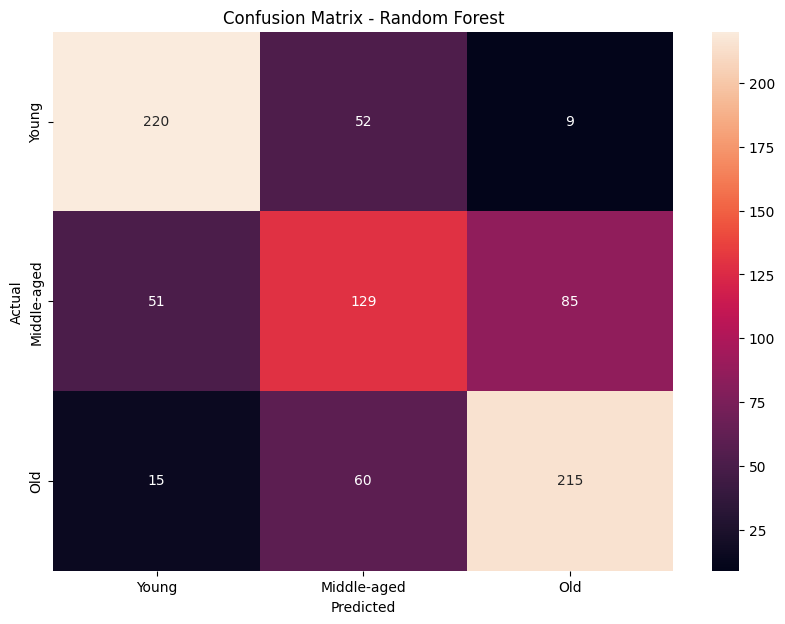

Per-class accuracy (RF):
Young: 0.7829
Middle-aged: 0.4868
Old: 0.7414


In [ ]:
# 10A) Train + Evaluate (Random Forest)
print("\n=== Classification: Random Forest ===")
clf_rf.fit(X_train_c, y_train_c)
y_pred_rf = clf_rf.predict(X_test_c)

acc_rf = accuracy_score(y_test_c, y_pred_rf)
print(f"Accuracy: {acc_rf:.4f}\n")

print("Classification report:")
print(classification_report(y_test_c, y_pred_rf, digits=4))

cm_rf = confusion_matrix(y_test_c, y_pred_rf, labels=["Young", "Middle-aged", "Old"])
plt.figure()
sns.heatmap(cm_rf, annot=True, fmt="d",
            xticklabels=["Young", "Middle-aged", "Old"],
            yticklabels=["Young", "Middle-aged", "Old"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("Per-class accuracy (RF):")
row_sums = cm_rf.sum(axis=1)
for i, cls in enumerate(["Young", "Middle-aged", "Old"]):
    cls_acc = cm_rf[i, i] / row_sums[i] if row_sums[i] > 0 else 0
    print(f"{cls}: {cls_acc:.4f}")

PART B: REGRESSION (Predict Age)

In [ ]:
# 7B) Train-test split (no stratify needed)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X,
    y_reg,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print("\n[Regression] Train size:", X_train_r.shape[0])
print("[Regression] Test size :", X_test_r.shape[0])


[Regression] Train size: 3341
[Regression] Test size : 836


In [ ]:
# 8B) Models
reg_lin = Pipeline(steps=[
    ("prep", preprocess),
    ("model", LinearRegression())
])

reg_rf = Pipeline(steps=[
    ("prep", preprocess),
    ("model", RandomForestRegressor(
        n_estimators=400,
        random_state=RANDOM_STATE
    ))
])

def eval_regression(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"\n=== Regression: {name} ===")
    print(f"MAE : {mae:.4f}")
    print(f"MSE : {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R^2 : {r2:.4f}")

    # Scatter plot: actual vs predicted
    plt.figure()
    plt.scatter(y_test, y_pred, alpha=0.6)
    plt.title(f"Actual vs Predicted Age - {name}")
    plt.xlabel("Actual Age")
    plt.ylabel("Predicted Age")
    plt.show()

    return y_pred


=== Regression: Linear Regression ===
MAE : 1.5931
MSE : 4.8912
RMSE: 2.2116
R^2 : 0.5482


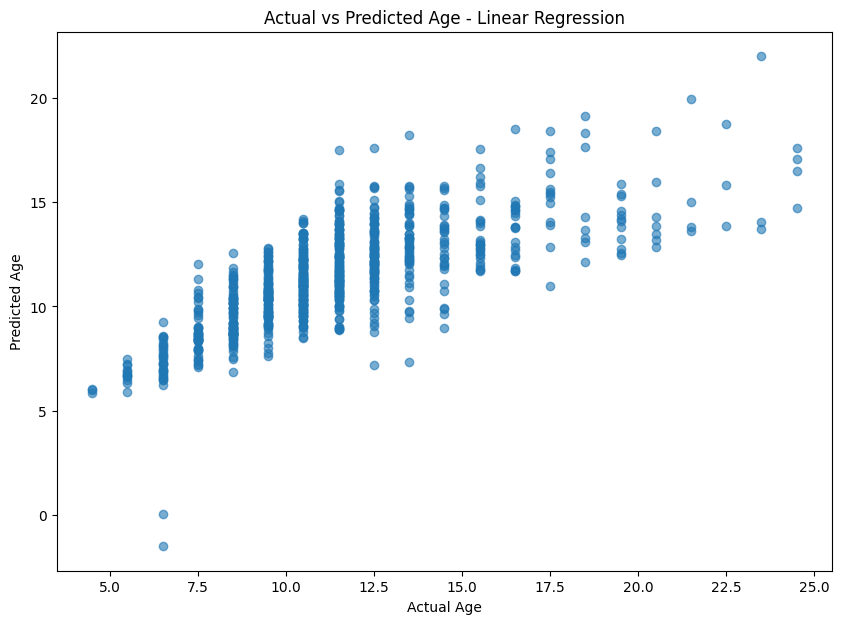

In [ ]:
# 9B) Train + Evaluate (Linear Regression)
reg_lin.fit(X_train_r, y_train_r)
_ = eval_regression("Linear Regression", reg_lin, X_test_r, y_test_r)



=== Regression: Random Forest Regressor ===
MAE : 1.5747
MSE : 5.0025
RMSE: 2.2366
R^2 : 0.5379


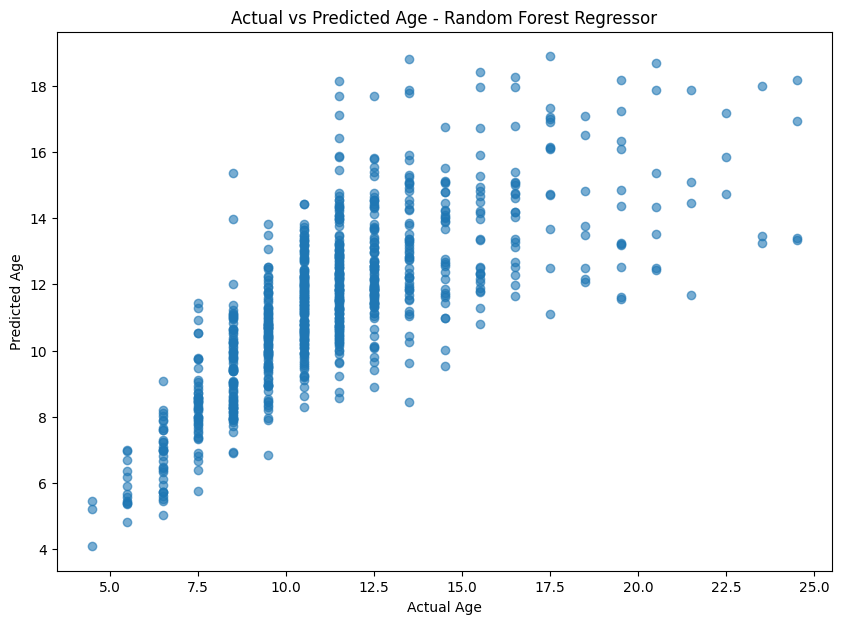

In [ ]:
# 10B) Train + Evaluate (Random Forest Regressor)
reg_rf.fit(X_train_r, y_train_r)
_ = eval_regression("Random Forest Regressor", reg_rf, X_test_r, y_test_r)
